<a href="https://colab.research.google.com/github/KimaniKibuthu/pneumonia-classification/blob/main/Pneumonia_Image_Classification_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Classification

The dataset contains x ray images of lungs with pneumonia and those without. Goal is to create a model that accurately predicts that someone has pneumonia or not.



# Import the necessary libraries

In [2]:
# General libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Modelling libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3

In [3]:
# Variables

TARGET_SIZE = 512
TEST_SIZE = 0.5
BATCH_SIZE = 64
RANDOM_STATE = 42
EPOCHS = 10
LR = 0.0001
WEIGHTS = {
    0:1.95,
    1:0.67
}

# Load data

In [4]:
# Load credentials
def credentials(name, token_id):
   # Setup the username and ID
  os.environ["KAGGLE_USERNAME"] = name
  os.environ["KAGGLE_KEY"] = token_id

  print('Done!')

In [5]:
# Download data
credentials('kimanikibuthu', 'f85c0bb5d43058fddcce7902e1325677')

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Done!
 99% 2.28G/2.29G [00:30<00:00, 18.8MB/s]
100% 2.29G/2.29G [00:30<00:00, 81.1MB/s]


In [6]:
# Unzip the data'
!unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [7]:
# Define paths
train_path = '/content/chest_xray/train'
test_path = '/content/chest_xray/test'
validation_path = '/content/chest_xray/val'

CLASSES = ['NORMAL', 'PNEUMONIA']

# Data Preprocessing

**General Exploration**

In [8]:
# Check for the number of images
for category in CLASSES:
  print(f'In the train data, {category} has {len(os.listdir(os.path.join(train_path, category)))} images')
  print(f'In the validation data, {category} has {len(os.listdir(os.path.join(validation_path, category)))} images')
  print(f'In the test data, {category} has {len(os.listdir(os.path.join(test_path, category)))} images')

In the train data, NORMAL has 1341 images
In the validation data, NORMAL has 8 images
In the test data, NORMAL has 234 images
In the train data, PNEUMONIA has 3875 images
In the validation data, PNEUMONIA has 8 images
In the test data, PNEUMONIA has 390 images


The training dataset is pretty imbalanced, with normal lung images making up **25%** of the dataset and lungs with pneumonia making up **75%**.

**Combine the training and validation**

Combine the train and validation sets and create a validation set that is 10% of the training set. 

In [9]:
def dataframe_creator(list_of_directories):
  files_final = np.array([])
  labels_final = np.array([])
  for directory in list_of_directories:
    files = np.array(os.listdir(directory))
    label = directory.split('/')[-1]
    labels = np.full_like(files, label)

    # update 
    files_final = np.append(files_final, files)
    labels_final = np.append(labels_final, labels)

  dataframe = pd.concat([pd.DataFrame(files_final, columns=['files']), 
                        pd.DataFrame(labels_final, columns=['labels'])],
                        axis=1)
  
  return dataframe


In [10]:
# List of directories
val_list_of_directories = ['/content/chest_xray/val/NORMAL',
                           '/content/chest_xray/val/PNEUMONIA']
train_list_of_directories = ['/content/chest_xray/train/NORMAL',
                             '/content/chest_xray/train/PNEUMONIA']


In [11]:
# Create dataframes
val_df = dataframe_creator(val_list_of_directories)
train_df = dataframe_creator(train_list_of_directories) 

# Concatenate dataframes
total_df = pd.concat([train_df, val_df], ignore_index=True)

total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5232 entries, 0 to 5231
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   files   5232 non-null   object
 1   labels  5232 non-null   object
dtypes: object(2)
memory usage: 81.9+ KB


In [12]:
# Split the data
train_set, val_set = train_test_split(total_df, 
                                      test_size = 0.1,
                                      random_state = 42,
                                      stratify= total_df['labels'])


train_set.reset_index(drop=True, inplace=True)
val_set.reset_index(drop=True, inplace=True)

In [13]:
# Combine the dwo directories
def directory_combiner(path1, path2, name, data):
  # Create directory'
  import shutil
  path = os.path.join('/content/chest_xray', name)
  if not os.path.exists(path):
    os.makedirs(path)
  
  images = data['files'].values
  folders = ['NORMAL', 'PNEUMONIA']
  train_normal_dirs = os.listdir(os.path.join(path1, 'NORMAL'))
  train_pneumonia_dirs = os.listdir(os.path.join(path1, 'PNEUMONIA'))
  val_normal_dirs = os.listdir(os.path.join(path2, 'NORMAL'))
  val_pneumonia_dirs = os.listdir(os.path.join(path2, 'PNEUMONIA'))
  
  for image in images:
    if image in train_normal_dirs:
      image_source_path = os.path.join('/content/chest_xray/train/NORMAL', image)
      destination_path = os.path.join(path, image)
      shutil.copy(image_source_path, destination_path )
    
    elif image in train_pneumonia_dirs:
      image_source_path = os.path.join('/content/chest_xray/train/PNEUMONIA', image)
      destination_path = os.path.join(path, image)
      shutil.copy(image_source_path, destination_path )

    elif image in val_normal_dirs:
      image_source_path = os.path.join('/content/chest_xray/val/NORMAL', image)
      destination_path = os.path.join(path, image)
      shutil.copy(image_source_path, destination_path )

    elif image in val_pneumonia_dirs:
      image_source_path = os.path.join('/content/chest_xray/val/PNEUMONIA', image)
      destination_path = os.path.join(path, image)
      shutil.copy(image_source_path, destination_path )
  

In [14]:
# Create dataframe
directory_combiner(train_path, validation_path, 'train_validation', total_df)

In [15]:
# Check for the number of images
combined_path = '/content/chest_xray/train_validation'
len(os.listdir(combined_path))

5232

**Show images**

In [16]:
# View the data
def show_images(base_path, class_name):
    # Get images 
    print(f'{class_name}')
    path = os.path.join(base_path, class_name)
    images = os.listdir(path)
    # Extract 16 random images from it
    random_images = [np.random.choice(images) for i in range(8)]

    # Adjust the size of your images
    plt.figure(figsize=(16,12))

    # Iterate and plot random images
  
    for i in range(8):
        plt.subplot(2,4,i+1)
        img = plt.imread(os.path.join(path, random_images[i]))
        
        try:
          plt.imshow(img, cmap='gray')
          #plt.axis('off')
        except FileNotFoundError:
          pass

    # Adjust subplot parameters to give specified padding
    plt.tight_layout() 

NORMAL


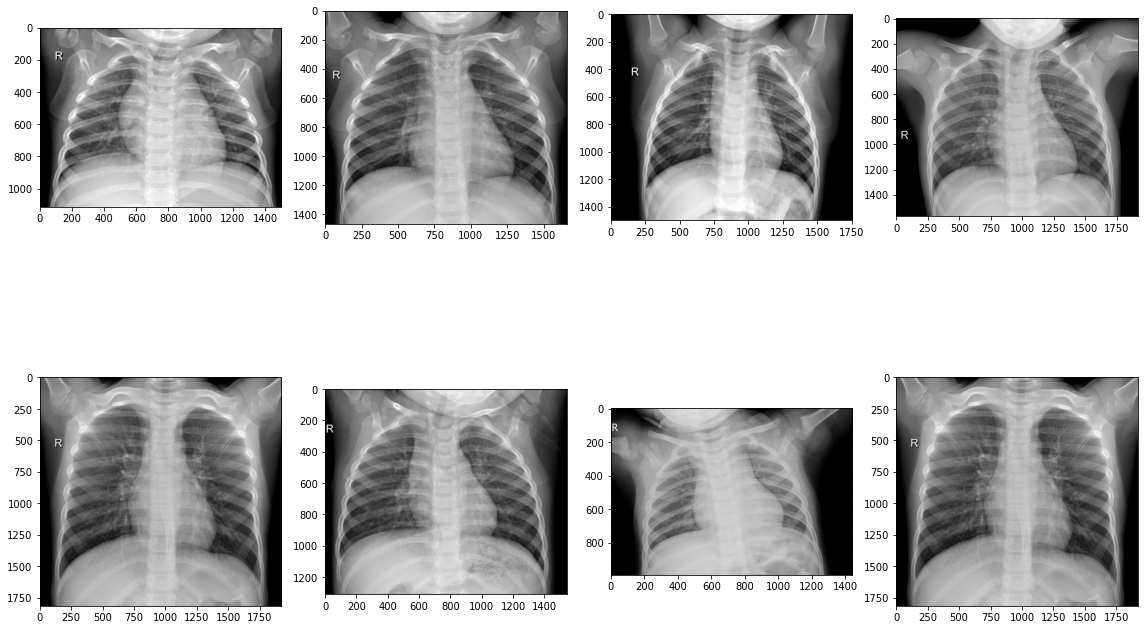

In [17]:
# Train images (NORMAL)
show_images(train_path, 'NORMAL')

PNEUMONIA


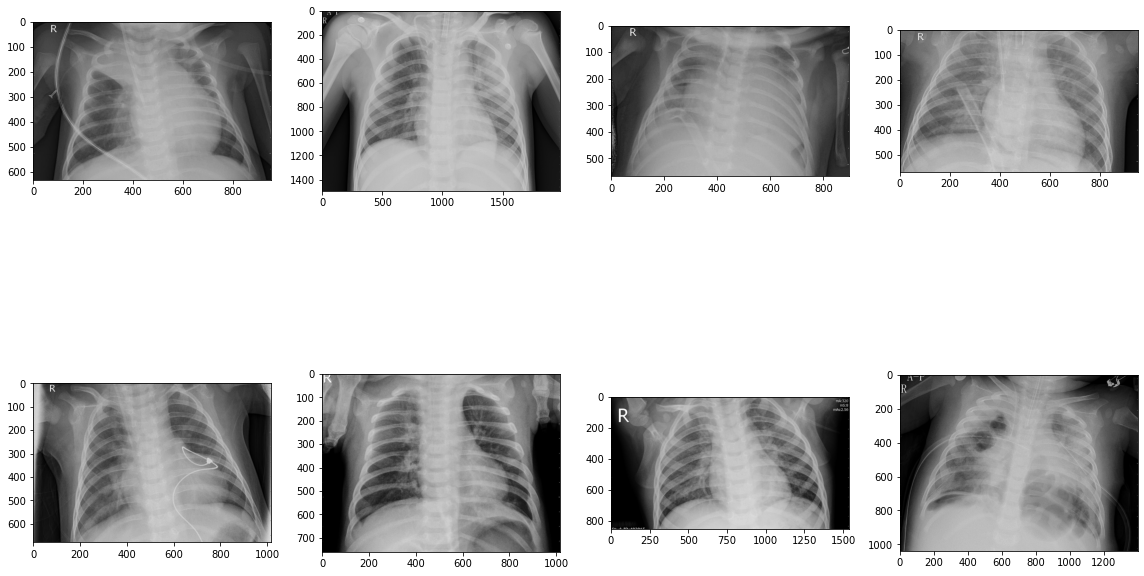

In [18]:
# Train images (PNEUMONIA)
show_images(train_path, 'PNEUMONIA')

NORMAL


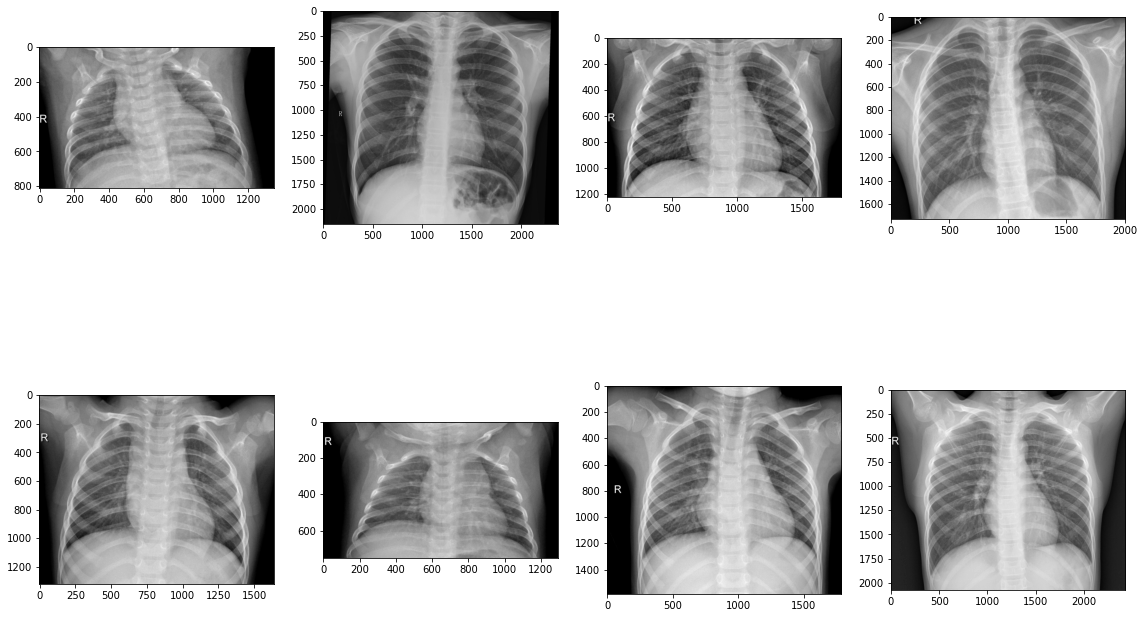

In [19]:
# Test images (NORMAL)
show_images(test_path, 'NORMAL')

PNEUMONIA


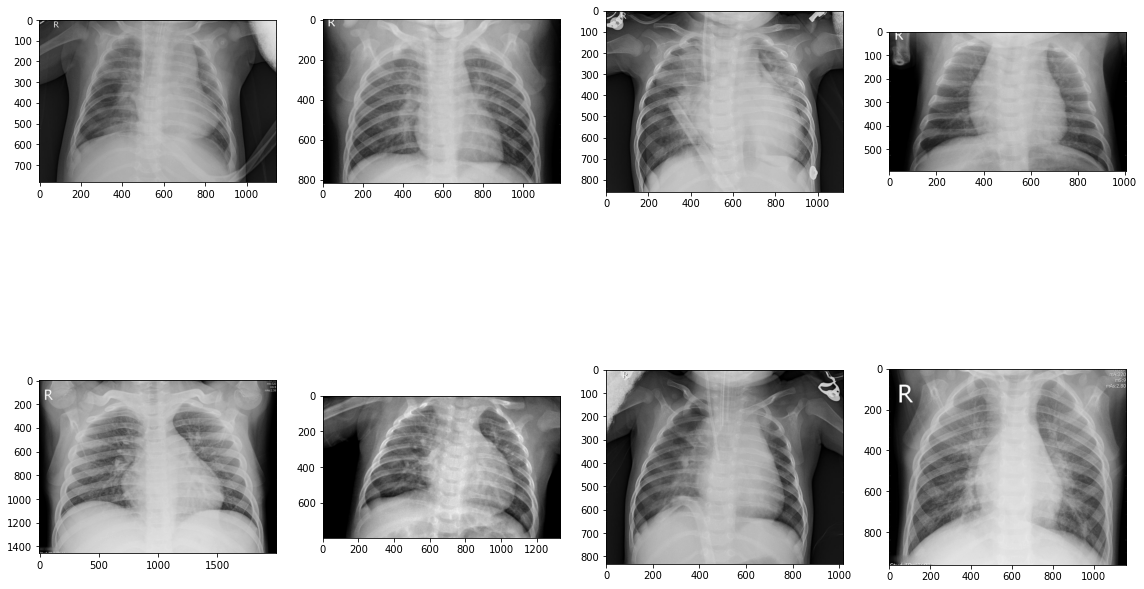

In [20]:
# Test images (PNEUMONIA)
show_images(test_path, 'PNEUMONIA')

NORMAL


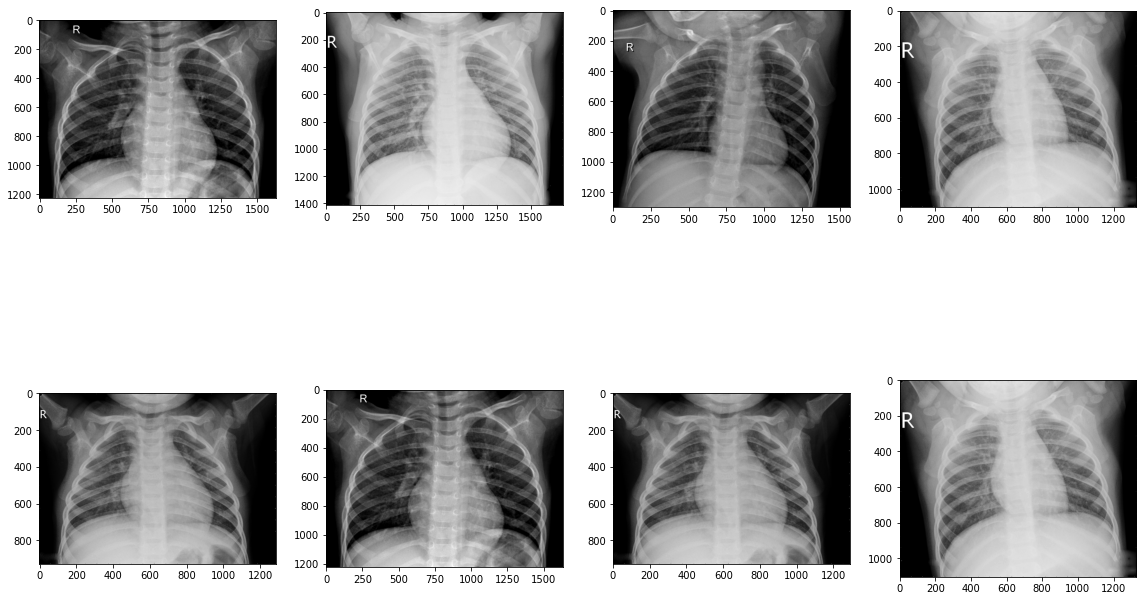

In [21]:
# Val images (NORMAL)
show_images(validation_path, 'NORMAL')

PNEUMONIA


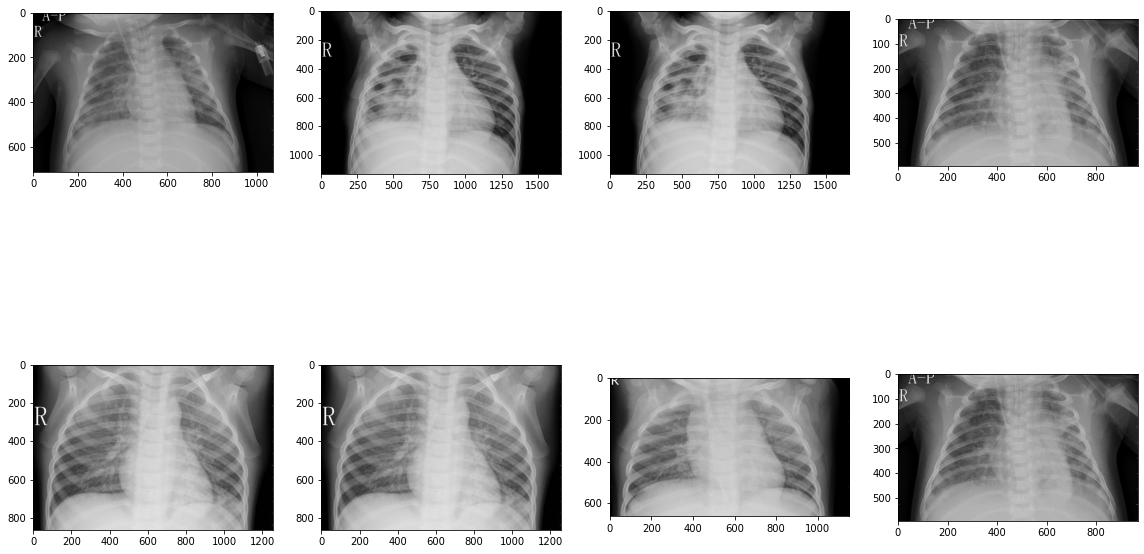

In [22]:
# Val images (PNEUMONIA)
show_images(validation_path, 'PNEUMONIA')

**Preprocessing and Creation of Generators**

With the data generators, the thing we could do is apply the preprocessing function.

In [23]:
# Create Generator objects
train_generator = ImageDataGenerator(
    # brightness_range = [0.8, 1.5],
    horizontal_flip = True,
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input 
)

val_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input 
)

test_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input 
)

In [24]:
# Create flows
train_flow = train_generator.flow_from_dataframe(train_set,
                                                 combined_path, 
                                                 x_col='files',
                                                 y_col = 'labels', 
                                                 target_size=(TARGET_SIZE, TARGET_SIZE), 
                                                 class_mode='binary',
                                                 batch_size = BATCH_SIZE)


val_flow = val_generator.flow_from_dataframe(val_set,
                                             combined_path,
                                             x_col='files',
                                             y_col = 'labels', 
                                             target_size=(TARGET_SIZE, TARGET_SIZE), 
                                             class_mode='binary',
                                             batch_size = BATCH_SIZE)

test_flow = test_generator.flow_from_directory(test_path,
                                                 target_size=(TARGET_SIZE, TARGET_SIZE),
                                                 class_mode='binary',
                                                 batch_size = BATCH_SIZE)

Found 4708 validated image filenames belonging to 2 classes.
Found 524 validated image filenames belonging to 2 classes.
Found 624 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


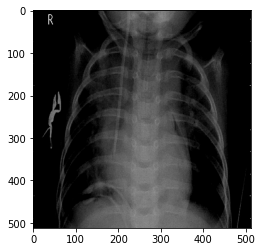

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


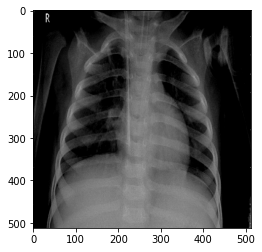

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


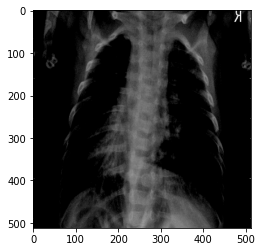

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


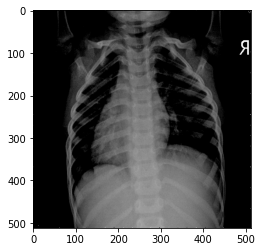

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


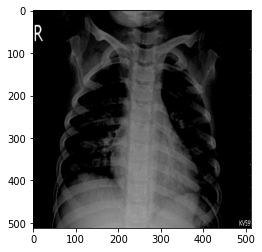

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


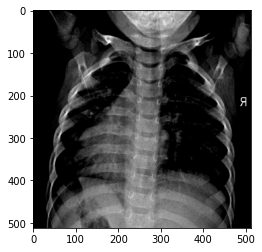

In [25]:
x_batch, y_batch = next(train_flow)
for i in range (0,6):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()

# Modelling

In [26]:
NUM_CLASSES = 2

bias = np.log([1341/3875])

In [27]:
def create_model():
  global NUM_CLASSES
  # Build model
  inception = InceptionV3(include_top=False, 
                          input_shape=(TARGET_SIZE, TARGET_SIZE, 3),
                          weights='imagenet')
  
  for layer in inception.layers:
    layer.trainable = False

  model = Sequential([
                      
                      inception,
                      GlobalAveragePooling2D(),
                      #Flatten(),
                      Dense(256, activation = 'relu', 
                           bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, 
                                                                       l2=0.001)),
                      Dropout(0.8),
                      Dense(32, activation = 'relu',
                            bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01,
                                                                        l2=0.001)),
                      Dropout(0.8),
                      Dense(1, activation = 'sigmoid',
                            bias_initializer= tf.keras.initializers.Constant(bias))
  ])

  # Instantiate learning rate and optimizer
  loss = tf.keras.losses.BinaryCrossentropy(from_logits = False,
                                                   label_smoothing=0.01,
                                                   name='binary_crossentropy' )

  adam = tf.keras.optimizers.Adam(LR)

  auc = tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC')
  precision = tf.keras.metrics.Precision(name='Precision')
  recall = tf.keras.metrics.Recall(name='Recall')
  
  # Compile model
  model.compile(loss = loss,
                optimizer = adam,
                metrics = ['binary_accuracy', auc, precision])
  
  return model
  

In [31]:
def model_fitter(model):

  # instantiate callbacks
  
  early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                                 patience=5)

  # reduce learning rate
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_binary_accuracy',
                                  factor = 0.1,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)

  callbacks = [early_stopper, reduce_lr]

  # Train model
  history = model.fit(train_flow,
                    epochs=EPOCHS,
                    steps_per_epoch=int(np.ceil(train_flow.samples)/BATCH_SIZE),
                    callbacks=callbacks,
                    validation_data=val_flow,
                    validation_steps=int(np.ceil(val_flow.samples)/BATCH_SIZE), 
                    class_weight = WEIGHTS
                    )
  
  return history, model

In [32]:
# Create model
model = create_model()

In [33]:
# Train model
history, model = model_fitter(model)

Epoch 1/10
73/73 [==============================] - 90s 1s/step - loss: 0.7913 - binary_accuracy: 0.4220 - auc_1: 0.5501 - Precision: 0.7912 - val_loss: 0.7825 - val_binary_accuracy: 0.2715 - val_auc_1: 0.9244 - val_Precision: 1.0000
Epoch 2/10
73/73 [==============================] - 85s 1s/step - loss: 0.6795 - binary_accuracy: 0.4966 - auc_1: 0.6540 - Precision: 0.8598 - val_loss: 0.6570 - val_binary_accuracy: 0.5488 - val_auc_1: 0.9576 - val_Precision: 1.0000
Epoch 3/10
73/73 [==============================] - 85s 1s/step - loss: 0.6352 - binary_accuracy: 0.5450 - auc_1: 0.7091 - Precision: 0.9117 - val_loss: 0.5606 - val_binary_accuracy: 0.7383 - val_auc_1: 0.9727 - val_Precision: 0.9960

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 4/10
73/73 [==============================] - 85s 1s/step - loss: 0.5849 - binary_accuracy: 0.5870 - auc_1: 0.7680 - Precision: 0.9381 - val_loss: 0.5193 - val_binary_accuracy: 0.8105 - val_auc_1: 0.9711 - val_P

In [35]:
 def plot_interactive_figures(model_history, metric, all=True, test_data=True):
    """
    Plot the performance metrics of the model


    :param model_history: history

    The model history obtained from model.fit()

    :param metric: str
    The performance metric you want to use.**loss**, **Precision**

    :param all: bool
    default=True. If true, overrides metric and plots figures of Precision and loss.
    If false, plots the metric defined.

    :param test_data: bool
    default = True.
    If you have used validation data or not

    :return:
    Performance of the model
    """

    import plotly.graph_objects as go

    if all:
        if test_data:
            acc = model_history.history['Precision']
            val_acc = model_history.history['val_Precision']

            loss = model_history.history['loss']
            val_loss = model_history.history['val_loss']
            epochs = list(range(len(acc)+1))
            # Plots
            ax = go.Figure()
            ax.add_trace(go.Scatter(x=epochs, y=val_acc, name='Validation Precision',
                                    line=dict(color='yellow', width=4)))
            ax.add_trace(go.Scatter(x=epochs, y=acc, name='Train Precision',
                                    line=dict(color='blue', width=4)))
            ax.update_layout(title='Train and Validation Precision plots',
                             xaxis_title='Epochs',
                             yaxis_title='Precision')
            ax.show()

            bx = go.Figure()
            bx.add_trace(go.Scatter(x=epochs, y=val_loss, name='Validation Loss',
                                    line=dict(color='yellow', width=4)))
            bx.add_trace(go.Scatter(x=epochs, y=loss, name='Train Loss',
                                    line=dict(color='blue', width=4)))
            bx.update_layout(title='Train and Validation Loss plots',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            bx.show()

        if not test_data:
            acc = model_history.history['Precision']
            loss = model_history.history['loss']
            epochs = list(range(len(acc)+1))

            cx = go.Figure()
            cx.add_trace(go.Scatter(x=epochs, y=acc, name='Precision',
                                    line=dict(color='blue', width=4)))
            cx.update_layout(title='Precision plot',
                             xaxis_title='Epochs',
                             yaxis_title='Precision')
            cx.show()

            dx = go.Figure()
            dx.add_trace(go.Scatter(x=epochs, y=loss, name='Loss',
                                    line=dict(color='yellow', width=4)))
            dx.update_layout(title='Loss plot',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            dx.show()

    if not all:
        if test_data:
            value_train = model_history.history[metric]
            value_test = model_history.history['val_{}'.format(metric)]
            epochs = list(range(len(value_train)+1))

            ex = go.Figure()
            ex.add_trace(go.Scatter(x=epochs, y=value_test, name='Validation {}'.format(metric),
                                    line=dict(color='yellow', width=4)))
            ex.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            ex.update_layout(title='Train and Validation {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            ex.show()

        if not test_data:
            value_train = model_history.history[metric]
            epochs = list(range(len(value_train)+1))

            fx = go.Figure()
            fx.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            fx.update_layout(title='Train {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            fx.show()


In [36]:
plot_interactive_figures(history, 'Precision')

In [38]:
predictions = model.predict(val_flow)

In [39]:
predictions

array([[0.52694035],
       [0.7594991 ],
       [0.40450257],
       [0.60853577],
       [0.2762536 ],
       [0.5843748 ],
       [0.49772125],
       [0.26913458],
       [0.23942365],
       [0.23899315],
       [0.6938642 ],
       [0.3016884 ],
       [0.7058504 ],
       [0.23441777],
       [0.4263628 ],
       [0.7482144 ],
       [0.3055638 ],
       [0.7495512 ],
       [0.22083297],
       [0.2855008 ],
       [0.39698622],
       [0.6465191 ],
       [0.265454  ],
       [0.42622805],
       [0.5954954 ],
       [0.59229237],
       [0.32797343],
       [0.5736391 ],
       [0.71642315],
       [0.38583043],
       [0.57132787],
       [0.51003987],
       [0.5496325 ],
       [0.33043364],
       [0.464786  ],
       [0.49346575],
       [0.52264416],
       [0.45566818],
       [0.5908885 ],
       [0.37805766],
       [0.7276069 ],
       [0.66317487],
       [0.5667955 ],
       [0.5238498 ],
       [0.54266536],
       [0.46229413],
       [0.5043653 ],
       [0.776

In [40]:
preds = np.int0(np.around(predictions))

In [41]:
len(val_flow.classes)

524

In [42]:
preds_true = np.reshape(val_flow.classes, (524,1))

In [43]:
# import metrics
from sklearn.metrics import classification_report, roc_auc_score

In [44]:
# Verify
print(f'The roc score is {roc_auc_score(preds_true, preds)}')
print(classification_report(preds_true, preds))

The roc score is 0.4975911644292107
              precision    recall  f1-score   support

           0       0.26      0.43      0.32       135
           1       0.74      0.57      0.64       389

    accuracy                           0.53       524
   macro avg       0.50      0.50      0.48       524
weighted avg       0.62      0.53      0.56       524



In [45]:
# Evaluate model
model.evaluate(val_flow)

9/9 [==============================] - 9s 889ms/step - loss: 0.5109 - binary_accuracy: 0.8168 - auc_1: 0.9729 - Precision: 0.9933


[0.5108629465103149,
 0.8167939186096191,
 0.9729410409927368,
 0.9932659864425659]

In [46]:
# Evaluate model
model.evaluate(test_flow)

10/10 [==============================] - 15s 1s/step - loss: 0.5039 - binary_accuracy: 0.8349 - auc_1: 0.9209 - Precision: 0.9135


[0.5039299726486206,
 0.8349359035491943,
 0.9208635091781616,
 0.9135446548461914]

In [47]:
# Save model
model.save('tuned_model.h5')

In [79]:
# Test on images
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(TARGET_SIZE, TARGET_SIZE))
  x = image.img_to_array(img)
  x = image.img_to_array(img)
  x = tf.keras.applications.mobilenet.preprocess_input(x)
  x = np.reshape(x, (1,512,512,3))

  images = np.vstack([x])
  classes = model.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " has pneumonia")
  else:
    print(fn + " is a healthy")

Saving IM-0007-0001.jpeg to IM-0007-0001 (6).jpeg
IM-0007-0001.jpeg is a healthy
